## Setup

First, we set up our notebook by downloading the appropriate packages

### Dependencies

In [2]:
pip install matplotlib scipy pandas numpy networkx seaborn scikit-learn cython

Note: you may need to restart the kernel to use updated packages.


### Imports

In [3]:
# base libraries
import importlib
import pandas as pd
import numpy as np

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

import os

import networkx as nx

import time

from IPython.utils.io import capture_output # supress outputs

from sklearn.metrics.cluster import adjusted_rand_score

### Fix pathway

In [4]:
# fix directory
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
os.chdir(parent_dir)

print("Current working directory:", os.getcwd())

from trcrpm.src import Hierarchical_TRCRP_Mixture, TRCRP_Mixture

Current working directory: /hdsi-collab-persistent/cephfs/Setup


### Helper Functions

1. **`run_model(data, num_chains = 8, p = 5, MCMC_steps=1000, hyperparam_steps=50, runtime = True)`**
    - **Returns**: Fitted model
        - The dataframe index needs to be reset as an integer.
        - Choose a high number for `MCMC_steps` to allow for a burn-in period.
        - `p` is our lag window

2. **`post_dep(model, num_samples)`**
    - **Returns**: Pairwise posterior dependence matrices (cluster probabilities)
        - The array is of size `NUM_SAMPLES x NUM_CHAINS x LEN(DF) x LEN(DF)`

3. **`clustering(post_probs, threshold = 0.75)`**
    - **Returns**: Clusters
        - If time series `i` and `k` are dependent in `threshold%` of samples, they are clustered together.
        - Averages over `NUM_SAMPLES` and `NUM_CHAINS`.

4. **`return_ari(true_labels, predicted_clusters)`**
    - **Returns**: Adjusted Rand Index (ARI) if ground truth is available


In [5]:
import importlib

In [6]:
import experiments.helper_functions as helpers
importlib.reload(helpers)

<module 'experiments.helper_functions' from '/hdsi-collab-persistent/cephfs/Setup/experiments/helper_functions.py'>

## Data Generation (Sin Waves)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.000000,1.000000,2.000000,0.000000,1.000000,2.000000,0.000000,1.000000,2.000000,0.000000,...,1.000000,2.000000,0.000000,1.000000,2.000000,0.000000,1.000000,2.000000,0.000000,1.000000
1,-0.698144,0.143767,0.211041,0.360933,0.387355,1.109317,0.113211,0.861154,0.438470,0.184232,...,0.202471,0.998971,0.566149,0.004983,-0.191486,-0.290226,-0.009635,0.334477,0.029989,-0.069286
2,-0.371716,-0.387578,2.204021,0.592673,-0.540718,2.886264,-0.181330,-0.568162,1.824790,0.540316,...,-1.137046,2.857236,-0.604883,-0.326535,3.195326,0.619083,-1.016713,3.210947,0.471778,-0.733543
3,0.274139,-2.368298,4.626330,0.203212,-2.004217,4.466122,0.334465,-1.240357,4.922399,0.799949,...,-1.548367,5.229193,0.579379,-1.585510,4.345932,-0.215621,-1.960955,4.888144,0.673766,-2.390926
4,0.151679,-2.218308,4.527189,0.421443,-2.068086,5.017570,-0.008722,-2.719934,5.385504,0.313718,...,-2.704944,5.195163,0.441936,-2.698113,4.993724,0.435381,-2.453055,4.366297,-0.045188,-2.736154


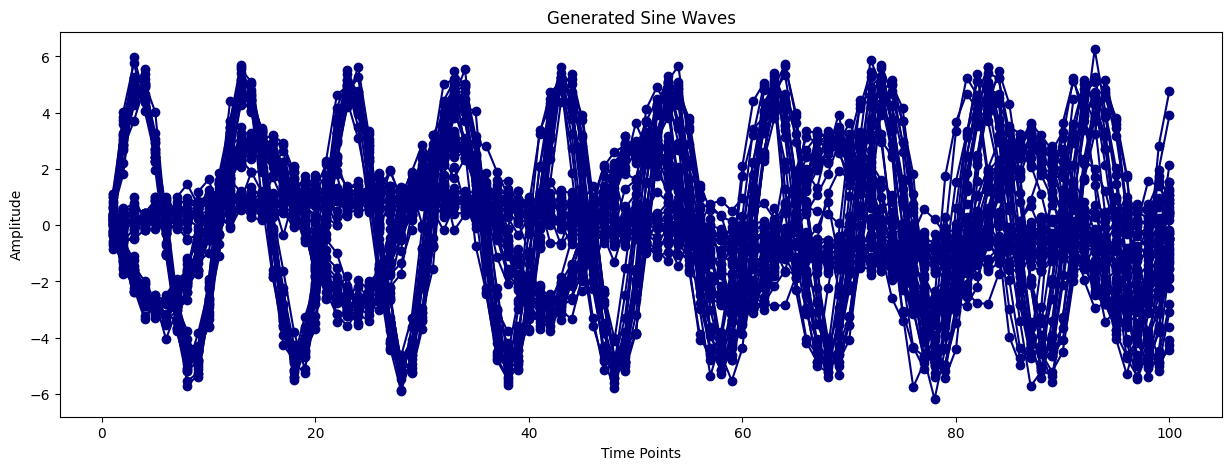

In [7]:
import experiments.data_generation as data_gen
importlib.reload(data_gen)

df = data_gen.generate_sine_wave_data(frequency_noise=0.1, random_state=42, use_colors = False, num_clusters = 3)
df.head()

## Run Analysis

In [8]:
data = df.iloc[1:]
labels = df.iloc[0].values

print(data.shape) # NUM_OBSERVATIONS X NUM_TIMESEREIES

(100, 50)


In [9]:
model = helpers.run_model(data)

MCMC inference time: 8 minutes and 35 seconds
Hyperparameter optimization time: 4 minutes and 41 seconds


In [10]:
dep_matrices = helpers.post_dep(model, 20)

Sampling Time: 2 minutes and 43 seconds


In [11]:
# compare predicted and true clusters

In [12]:
predicted_clusters = helpers.clustering(dep_matrices, threshold = 0.75)
predicted_clusters

[{0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48},
 {1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49},
 {2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47}]

In [13]:
helpers.return_ari(labels, predicted_clusters)

1.0

In [14]:
unique_labels = np.unique(labels)
# step size (number of elements per cluster)
step = len(labels) // len(unique_labels)

# clusters as list 
clusters = [[int(label) for label in np.where(labels == label)[0]] for label in unique_labels]
clusters

[[0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48],
 [1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49],
 [2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47]]

## Plotting


In [15]:
import plotting_functions as plot
importlib.reload(plot)

<module 'plotting_functions' from '/hdsi-collab-persistent/cephfs/Setup/experiments/plotting_functions.py'>

In [16]:
# %%capture
# # need to simulate samples for confidence interval
# # we sample from the posterior to get confidence interval for forecasted values
# # some bug inside .simulate so supressing outputs for now
# # bug is in cgpm.src.crosscat.sampling (print statement in simulate_row)
# probes = model.dataset.index
# numsamples = 10
# samples = model.simulate(probes, model.variables, numsamples)

### Plotting 2

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def plot_latent_state_sequence(timesteps, values, states, ax):
    assert len(timesteps) == len(states)
    unique = sorted(set(states))
    colors = plt.cm.Set1(np.linspace(0, 1, len(unique)))
    y_low, y_high = ax.get_ylim()
    y_mid = np.mean([y_low, y_high])
    y_height = 0.05 * (y_high - y_low)
    for state, color in zip(unique, colors):
        xs = timesteps[states == state]
        for x in xs:
            ax.fill_between([x-1, x], [y_mid-y_height]*2, [y_mid+y_height]*2,
                            alpha=0.3, color=color)

def plot_predictions(variable, ax, states_from_chain=None):
    index = model.variables.index(variable)
    # Plot the observed data.
    x_observed = model.dataset.index
    y_observed = model.dataset.loc[:, variable]
    ax.plot(x_observed, y_observed, label=variable, color='k', linewidth=1)
    ax.set_ylim([min(y_observed)-2, max(y_observed)+2])
    
    # Optionally plot latent temporal state at each timepoint,
    # according to a given chain in the model.
    if states_from_chain is not None:
        assert 0 <= states_from_chain < model.chains
        states = model.get_temporal_regimes(variable)[states_from_chain]
        plot_latent_state_sequence(x_observed, y_observed, states, ax)
    
    # Add the legend.
    ax.legend(loc='upper left', handletextpad=0)

def plot_cluster_variables(cluster_variables, ax, states_from_chain=None):
    # Define a colormap that provides a distinct color for each variable.
    colors = plt.cm.viridis(np.linspace(0, 1, len(cluster_variables)))

    for idx, variable in enumerate(cluster_variables):
        color = colors[idx]
        plot_predictions_with_labels(variable, ax, color, states_from_chain)

    ax.set_title("Clustered Variables Over Time")
    ax.set_xlabel("Time")
    ax.set_ylabel("Values")
    ax.legend(loc='upper left', handletextpad=0, frameon=True, fontsize='small')

def plot_predictions_with_labels(variable, ax, color, states_from_chain=None):
    index = model.variables.index(variable)
    x_observed = model.dataset.index
    y_observed = model.dataset.loc[:, variable]

    # Plot observed data with a label at the end of the line.
    line, = ax.plot(x_observed, y_observed, label=variable, color=color, linewidth=1.5)
    label_x_pos = x_observed[-1]
    label_y_pos = y_observed.iloc[-1]

    # Optional: plot the latent temporal state at each timepoint.
    if states_from_chain is not None:
        assert 0 <= states_from_chain < model.chains
        states = model.get_temporal_regimes(variable)[states_from_chain]
        plot_latent_state_sequence(x_observed, y_observed, states, ax)

# Example usage:
# fig, ax = plt.subplots()
# plot_cluster_variables(['variable1', 'variable2'], ax, states_from_chain=0)
# plt.show()


### Helper Functions 

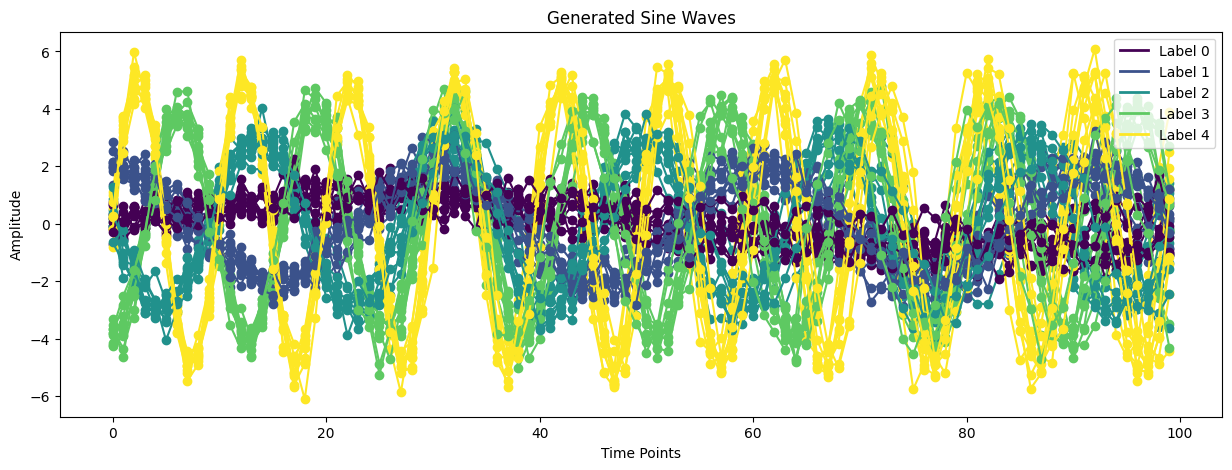

NameError: name 'p' is not defined

In [16]:
# compare labels with predicted_labels
plot.plot_df(data, labels)
#lot.plot_df(data, predicted_labels)

In [ ]:
plot.plot_cluster_variables(samples, [1, 6, 26, 41], ax, states_from_chain=2)


In [ ]:
# Example usage:
# fig, ax = plt.subplots()
# plot_cluster_variables(['variable1', 'variable2'], ax, states_from_chain=0)
# plt.show()